<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_5_1__Neural_Networks_Basics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Basics 1
## (Dive into Deep Learning https://d2l.ai/chapter_linear-networks/index.html)

* The material for this notebook is mainly from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa.

* Some figures are from Richard Szeliski's vision textbook for this course.

# Topics covered

* You will get introduced to the essential components that go into constructing and training neural networks

* You will be introduced to the linear regression problem and how it can be solved using stochastic gradient descent.

* You will learn how to backpropagate gradients by hand and apply those gradients to the model parameters


**Concepts Learned:** linear regression, model, train, mini-batches, *stochastic* gradient search, epochs, hyperparamters, backpropagation, squared loss function, fully connected layer, python data iterator.

## Code: setup

In [1]:
!pip install d2l==0.16.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F

# Linear Regression

* *Regression* refers to a set of methods for modeling the relationship between one or more **independent** variables and a **dependent** variable or the **predicted** variable.

* Examples: local images features (e.g., color values) to label objects in images;  video to label action type;  face image to label emotions


* We will implement the entire method from scratch, including

    1. the data pipeline,
    2. the model,
    3. the loss function, and
    4. the minibatch stochastic gradient descent optimizer.

* For now, we will rely only on tensors and auto differentiation. Afterward, we will introduce a more straightforward implementation, taking advantage of the bells and whistles of deep learning frameworks.


## Generating the Dataset

* We construct an artificial dataset according to a linear model with additive noise.

* Our task will be to recover this model's parameters using the finite set of examples in our dataset.

* In the following code snippet, we generate a dataset, $\mathbf{X}$, containing 1000 examples, each consisting of 2 features sampled from a standard normal distribution. Thus our synthetic dataset will be a $1000 \times 2$ matrix.

* This input data is transformed linearly using

\begin{equation}
\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon
\end{equation}

* $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and $\epsilon$ captures potential measurement errors on the features and labels.

* We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with a mean of 0.
    * To make our problem easy, we will set its standard deviation to 0.01.


###Code: `generate_synthetic_data`

In [3]:
def generate_synthetic_data (w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = generate_synthetic_data (true_w, true_b, 1000)

In [4]:
features.size()

torch.Size([1000, 2])

* **Note that each row in `features` consists of a 2-dimensional data example and that each row in `labels` consists of a 1-dimensional label value (a scalar).**


In [5]:
print('First 10 features:\n', features[1:10,:], '\nFirst 10 labels:\n', labels[1:10])

First 10 features:
 tensor([[ 1.3333,  0.6215],
        [ 0.0783,  0.8594],
        [-0.7268,  0.2376],
        [ 0.5259, -1.0226],
        [ 1.2576,  0.1750],
        [-0.1084,  0.3516],
        [ 0.0584,  0.3716],
        [-2.5363, -0.6872],
        [ 1.5429,  1.8232]]) 
First 10 labels:
 tensor([[4.7523],
        [1.4284],
        [1.9417],
        [8.7313],
        [6.1190],
        [2.7856],
        [3.0543],
        [1.4657],
        [1.0814]])


* **Observe the linear correlation between the input and the output.**


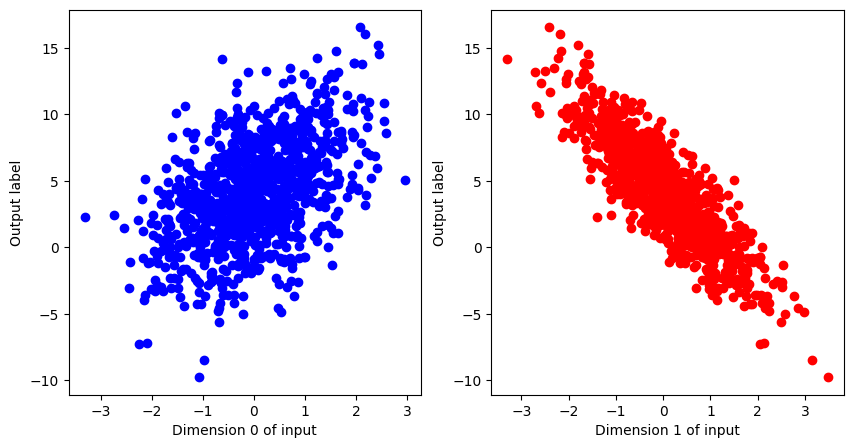

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches (10, 5)

ax[0].scatter(features[:, 0].detach().numpy(),
                labels.detach().numpy(), c='b')
ax[0].set_xlabel('Dimension 0 of input')
ax[0].set_ylabel('Output label')

ax[1].scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), c='r')
ax[1].set_xlabel('Dimension 1 of input')
ax[1].set_ylabel('Output label');

## Reading the Dataset

* Estimating the linear model parameters from the training data involve iterations over the dataset.

* Recall how **gradient descent** or Newton's method (with Hessian) worked for 2D perspective transformation (homography) estimation.

    * At each iteration, we computed a gradient value based on the **entire** dataset.

* Here, we adopt **stochastic** gradient descent, which works well in practice.

    * Instead of considering the entire dataset at each iteration, we
form many subsets of the data and use the subsets to update our model, one at a time.

* We break the dataset into **mini-batches**, each consisting of **batch size** number of data samples. Each minibatch consists of a tuple of input features and labels.

    * At each iteration, we compute the gradient based on one minibatch at a time.

    * Updates from the different subsets of the data are randomly varying, which gives its name *stochastic*.

    *  Minibatches sizes depend on available GPU hardware. We can also compute the gradient of the loss function for each example in parallel; GPUs allow us to process hundreds of inputs in scarcely more time than it might take to process just a single sample.

* Since this process is so fundamental to training machine learning algorithms,
it is worth defining a utility function to shuffle the dataset and access it in mini-batches.

    * In the following code, we define the **`data_iter` function** to demonstrate one possible implementation of this functionality. The function takes a **batch size, a matrix of features, and a vector of labels, yielding mini-batches of the size `batch_size.`**


### Code: Some python background about iterators, generators

* An iterator in Python is an object that contains a finite number of elements that can be iterated upon, i.e. go through the ordered collection  one element at a time.

* A generator is a special type of function which returns an iterator object.  *It can be run only once*.

In [7]:
'''
Some python background about iterators, generators, and yield that we will use.
Example taken from https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
'''
mylist = [1, 2, 3]
for i in mylist:
    print(i)

1
2
3


In [8]:
# --------Iterator object--------------------
# An iterator in Python is an object that contains a finite number of
# elements that can be iterated upon, i.e. go through the ordered collection
# one element at a time.

print('Iterator output (first run):')
mylist = [x*x for x in range(3)]
for i in mylist:
    print(i)

print('Iterator output (second run):')
for i in mylist:
    print(i)


Iterator output (first run):
0
1
4
Iterator output (second run):
0
1
4


In [9]:
# ---------Generator object--------------------
# A generator is a special type of function which returns an iterator object.
# Can be run only once.

mygenerator = (x*x for x in range(3))
"note the use of parenthesis instead of brackets"
print('Mygenerator created using yield is:', mygenerator) # mygenerator is an object!

print('Generator output (first run):')
for i in mygenerator:
    print(i)

print('Generator output (second run):')
for i in mygenerator:
    print(i)

Mygenerator created using yield is: <generator object <genexpr> at 0x7f74a032c4a0>
Generator output (first run):
0
1
4
Generator output (second run):


In [10]:
#-----------Yield returns generator object--------
# In a generator function, a "yield" statement is used rather than a "return" statement.
# You use generators to create your own iterators.
# Can be run only once.

def create_generator():
    mylist = range(3)
    for i in mylist:
        yield i*i

mygenerator = create_generator() # create a generator
print('Mygenerator created using yield is:', mygenerator) # mygenerator is an object!
for i in mygenerator:
    print(i)

print('Mygenerator created using yield is (second run):', mygenerator) # mygenerator is an object!
for i in mygenerator:
    print(i)


Mygenerator created using yield is: <generator object create_generator at 0x7f74a02e8ac0>
0
1
4
Mygenerator created using yield is (second run): <generator object create_generator at 0x7f74a02e8ac0>


### Code: `data_iter` over randomized minibatches

In [11]:
import numpy as np

# Generator function over the data
def data_iter (batch_size, features, labels):
    num_examples = features.shape[0]
    # We randomly shuffle the data in the beginning so breakup any bias induced due to order of data
    indices = np.random.permutation (num_examples)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
" notice yield above"

' notice yield above'

* To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


* As we run the iteration, we obtain distinct mini-batches
successively until the entire dataset has been exhausted (try this).


* This method works but is inefficient, requiring that we load all the data in memory and perform lots of random memory access. **The built-in iterators implemented in a deep learning framework are considerably more efficient and can deal with data stored in files and data fed via data streams.** We will get introduced to them later.



In [12]:
batch_size = 11
# print first batch and then exit.
i = 1
for X, y in data_iter(batch_size, features, labels):
    print(i, X.size())
    i = i+1


1 torch.Size([11, 2])
2 torch.Size([11, 2])
3 torch.Size([11, 2])
4 torch.Size([11, 2])
5 torch.Size([11, 2])
6 torch.Size([11, 2])
7 torch.Size([11, 2])
8 torch.Size([11, 2])
9 torch.Size([11, 2])
10 torch.Size([11, 2])
11 torch.Size([11, 2])
12 torch.Size([11, 2])
13 torch.Size([11, 2])
14 torch.Size([11, 2])
15 torch.Size([11, 2])
16 torch.Size([11, 2])
17 torch.Size([11, 2])
18 torch.Size([11, 2])
19 torch.Size([11, 2])
20 torch.Size([11, 2])
21 torch.Size([11, 2])
22 torch.Size([11, 2])
23 torch.Size([11, 2])
24 torch.Size([11, 2])
25 torch.Size([11, 2])
26 torch.Size([11, 2])
27 torch.Size([11, 2])
28 torch.Size([11, 2])
29 torch.Size([11, 2])
30 torch.Size([11, 2])
31 torch.Size([11, 2])
32 torch.Size([11, 2])
33 torch.Size([11, 2])
34 torch.Size([11, 2])
35 torch.Size([11, 2])
36 torch.Size([11, 2])
37 torch.Size([11, 2])
38 torch.Size([11, 2])
39 torch.Size([11, 2])
40 torch.Size([11, 2])
41 torch.Size([11, 2])
42 torch.Size([11, 2])
43 torch.Size([11, 2])
44 torch.Size([11, 2

## Initializing model parameters

**Before we can begin optimizing our model's parameters** by minibatch stochastic gradient descent, (**we need to have some parameters in the first place.**). In the following code, we initialize weights by sampling random numbers from a normal distribution with a mean of 0 and a standard deviation of 0.01 and setting the bias to 0.


### Code: Initialize parameters (`w, b`)

In [13]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print('weights:\n', w, '\nb=\n', b)

weights:
 tensor([[-0.0184],
        [ 0.0141]], requires_grad=True) 
b=
 tensor([0.], requires_grad=True)


* After initializing our parameters, our next task is to update them until they fit our data sufficiently well.

* Each update requires taking the gradient of our loss function with respect to the parameters.

* To compute gradients explicitly, we use automatic differentiation to compute the gradient.


## Defining the Model

* Next, we must **define our model, relating its inputs and parameters to its outputs.**

* To calculate the output of the linear model, we take the matrix-vector dot product of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$, and add the offset $b$ to each example.

* The product $\mathbf{Xw}$  is a vector, and $b$ is a scalar.
    * We will use the *broadcasting* feature to add the scalar.


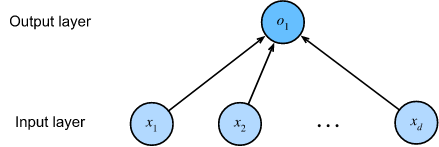

### Code: `linreg`: The linear regression model

In [14]:
def linreg(X, w, b):
    """The linear regression model."""
    # X is N by d, where N is the number of data elements, d is the dimension of the data
    # w is a d by 1 vector of parameters
    return torch.matmul(X, w) + b

## Defining the Loss Function

* Since updating our model requires taking the gradient of our loss function, we ought to (**define the loss function next**)

* We will use the **squared loss** function (**squared residuals**)

* Note that we do **not** sum the residuals yet. The function returns the residuals for **each** data point of the input.

* Some python implementation issue: although both `y` and `y_hat` are just a vector of numbers, they might be represented as 1D ($[n]$ sized) or as 2D ($[n,1]$ sized) arrays. We have to reshape one to fit the other.

* The result returned by the following function will also have the same shape as `y_hat`.



### Code: `squared_loss` function

In [15]:
def squared_loss(y_hat, y):
    """Squared loss."""
    # although both y and y_hat are just a vector of numbers,
    # they might be represented as [n] or as [n,1] arrays.
    # that is what we have to reshape one to fit the other.
    # Another option would have been to squeeze out the "1" dimension
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Stochastic gradient descent -- the optimization algorithm

* For each minibatch of `batch_size`,

    1. Estimate the gradient of the loss with respect to our parameters.
    2. Update the parameters (`params`) in the direction that may reduce the loss based on a learning rate (`lr`). Because we calculate our loss as a sum over the minibatch of examples, we normalize our step size by the batch size (`batch_size`), so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.

###Code: `stochastic_gradient_descent` function

In [16]:
def stochastic_gradient_descent (params, lr):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

## Training

* Now that we have all the parts in place, we are ready **to implement the main training loop**.

* It is crucial that you understand this code because you will see nearly identical training loops repeatedly throughout your career in deep learning.

* Initialize parameters $(\mathbf{w}, b)$
* At each iteration over the mini-batches of the *entire* dataset
    1. We will grab a minibatch of training examples,
    2. Pass minibatch through the model to obtain a set of predictions.
    3. Calculate the loss,
    3. Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
        * Initiate the backward pass through the network, computing and storing the gradients with respect to each parameter.
    5. Call `stochastic_gradient_descent` to update the model parameters.
        * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

* Each pass (using the `data_iter` function) through the dataset is called one **epoch**. To optimize, we need **multiple epochs**

* The number of epochs `num_epochs` and the learning rate `lr` are both **hyperparameters**, which we set here to 3 and 0.03, respectively.

* Unfortunately, setting hyperparameters is tricky.
Moreover, it requires some adjustment by trial and error.


###Code: Training

In [17]:
lr = 0.03 # learning rate
num_epochs = 10 # number of passes through the entire dataset
batch_size = 10
net = linreg
loss = squared_loss
print('Initial w=\n', w, '\nInitial b=\n', b)
print('True w=\n', true_w, '\nTrue b=\n', true_b)


Initial w=
 tensor([[-0.0184],
        [ 0.0141]], requires_grad=True) 
Initial b=
 tensor([0.], requires_grad=True)
True w=
 tensor([ 2.0000, -3.4000]) 
True b=
 4.2


In [18]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]

        l.mean().backward()

        stochastic_gradient_descent([w, b], lr)  # Update parameters using their gradient

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        #print('\nw=\n', w, '\nb=\n', b)
        print(f'epoch {epoch + 1}, w= {w.numpy().transpose()}, b= {b.numpy()}, loss {float(train_l.mean()):f}',)


epoch 1, w= [[ 1.8890538 -3.2162254]], b= [3.9887428], loss 0.043835
epoch 2, w= [[ 1.9938967 -3.3900938]], b= [4.188844], loss 0.000174
epoch 3, w= [[ 1.9995317 -3.3994713]], b= [4.1996026], loss 0.000049
epoch 4, w= [[ 2.000099  -3.4001048]], b= [4.1999784], loss 0.000048
epoch 5, w= [[ 1.9998661 -3.400308 ]], b= [4.2000027], loss 0.000048
epoch 6, w= [[ 2.0002007 -3.4000282]], b= [4.1998496], loss 0.000048
epoch 7, w= [[ 1.9997457 -3.399725 ]], b= [4.200024], loss 0.000048
epoch 8, w= [[ 2.0004876 -3.4004023]], b= [4.199948], loss 0.000048
epoch 9, w= [[ 2.0003517 -3.399966 ]], b= [4.2000947], loss 0.000048
epoch 10, w= [[ 1.9999834 -3.4000041]], b= [4.199904], loss 0.000048


In this case, because we synthesized the dataset ourselves, we precisely know the true parameters. Thus, we can **evaluate our success in training by comparing the true parameters with those that we learned** through our training loop. Indeed they turn out to be very close to each other.


In [19]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([1.6570e-05, 4.0531e-06], grad_fn=<SubBackward0>)
error in estimating b: tensor([9.5844e-05], grad_fn=<RsubBackward1>)


* Note that we should not take it for granted that we can recover the parameters perfectly. However, in machine learning, we are typically less concerned with recovering true underlying parameters and more concerned with parameters that lead to highly accurate predictions. Fortunately, even on complex optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate predictions.


# Backpropagation and Gradient Descent

Here we will understand the details of backpropagation and gradient descent and work out a simple numerical example by hand.





## Model Definition

Let's consider the linear model $\mathbf{y}= \mathbf{X} \mathbf{w}$, which has no bias. The variables $\mathbf{X}$ and $\mathbf{w}$, and $\mathbf{y}$ have the values as shown below:

  \begin{align}
    \mathbf{X} = \begin{bmatrix}
           2 & 1\\
         \end{bmatrix}, \quad
    \mathbf{w} = \begin{bmatrix}
           1 \\
           3 \\
         \end{bmatrix}, \quad
    \mathbf{y} = \begin{bmatrix}
           8 \\
         \end{bmatrix}
  \end{align}



The model can be plotted as follows:

![model](https://drive.google.com/uc?export=view&id=1Vy2BK8VhySZPWt2VAVYHEYu9OIKbVrwv)



In [20]:
# define input x and output label y
x = torch.tensor([[2.0, 1.0]])
y = torch.tensor([[8.0]])

# define the linear model
model = nn.Linear(2, 1, bias=False)
model.weight.data = torch.tensor([[1.0, 3.0]])

# print shapes
print(x.shape, model.weight.data.shape, y.shape)

torch.Size([1, 2]) torch.Size([1, 2]) torch.Size([1, 1])


## Forward pass

We first start by performing a forward pass through the model. **No gradients are calculated through the forward pass.**

![Forward pass](https://drive.google.com/uc?export=view&id=1ijOSmhIPD46RDWjhYnSATzjbaV2CVHiZ)


In [21]:
# Perform the forward pass
a = model(x)
a.retain_grad()

# Calculate the loss
loss = F.mse_loss(a, y)

# Print values
print(a, loss)

tensor([[5.]], grad_fn=<MmBackward0>) tensor(9., grad_fn=<MseLossBackward0>)


## Backward pass

* The goal is to use the values calculated in the forward pass to calculate the gradients w.r.t the weights $\textbf{w}$.
* We want to find the gradients $\frac{\partial \mathcal{L}}{\partial \boldsymbol{w1}}$ and $\frac{\partial \mathcal{L}}{\partial \boldsymbol{w2}}$. This is where the chain rule comes in:

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{w}} = \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}} * \frac{\partial \boldsymbol{a}}{\partial \boldsymbol{w}}
\end{equation}

#### MSE gradient

* The Mean Squared Error Loss is defined as $\mathcal{L} = \frac{1}{n} \sum_{i=1}^{n} (\boldsymbol{y}_i - \boldsymbol{a}_i)^2$, For our case $n=1$, therefore the expression reduces to $\mathcal{L} = (\boldsymbol{y} - \boldsymbol{a})^2$.
* We can take the gradient:

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}} = 2(\boldsymbol{y} - \boldsymbol{a})(-1) = -2(\boldsymbol{y} - \boldsymbol{a})
\end{equation}

#### Linear layer gradient
* The linear layer for two independant variables $\boldsymbol{x}_1, \boldsymbol{x}_2$ and one dependant variable $\boldsymbol{y}$ is calculated as $\boldsymbol{a} = \boldsymbol{x}_1 * \boldsymbol{w}_1 + \boldsymbol{x}_2 * \boldsymbol{w}_2$.
* We can take the gradients w.r.t the inputs:

\begin{equation}
\frac{\partial \mathcal{a}}{\partial \boldsymbol{w}_1} = \boldsymbol{x}_1 ,\quad
\frac{\partial \mathcal{a}}{\partial \boldsymbol{w}_2} = \boldsymbol{x}_2
\end{equation}


## Numerical gradient calculation


![Backward pass](https://drive.google.com/uc?export=view&id=1oS6MC02yBlHzApPrKuvD0b_ri_Zjre1n)


In [22]:
# Backwards pass
model.zero_grad()
loss.backward()

# print gradients on a
print(a.grad)

# print gradients on w
print(model.weight.grad)

tensor([[-6.]])
tensor([[-12.,  -6.]])


## But what does the gradient really mean?
$$\require{cancel}$$

Consider the gradient of $\mathcal{L}$ w.r.t. $\boldsymbol{a}$ (i.e., $\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}}$). We know from calculus that the derivative is defined as:

\begin{equation}
\lim_{h \to 0} \frac{f(\boldsymbol{a}+h)-f(\boldsymbol{a})}{h}
\end{equation}

This means that if we add a small value to $\boldsymbol{a}$, the final result of the main function will be proportional to the gradient. Therefore:

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}} = \frac{\Delta \mathcal{L}}{\Delta \boldsymbol{a}} = \frac{L(a+h,y) - L(a,y)}{(\cancel{a}+h)-\cancel{a}}
\end{equation}

When we substitute the values we have and the function definition of mean squared error, we get:

\begin{equation}
\frac{(y-(a+h))^2 - (y-a)^2}{h} = \frac{(8-(5+0.0001))^2-(8-5)^2}{0.0001} = \frac{-0.0006}{0.0001} = -6
\end{equation}

So changing $\boldsymbol{a}$ by a small amount of $-0.0001$ changes the Loss function $\mathcal{L}$ by the amount $0.0006$. **The ratio is the gradient**.

## Updating the model weights

### SGD Optimizer
* The SGD optimizer applies the gradient multiplied by a learning rate:

\begin{equation}
\boldsymbol{w}_1 = \boldsymbol{w}_1 - lr * \frac{\partial \mathcal{L}}{\partial \boldsymbol{w}_1} = 1.0 - (1.0*-12.0) = 13.0 \\
\boldsymbol{w}_2 = \boldsymbol{w}_2 - lr * \frac{\partial \mathcal{L}}{\partial \boldsymbol{w}_2} = 3.0 - (1.0*-6.0) = 9.0
\end{equation}

In [23]:
# define and step optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
optimizer.step()

# print new weights
print(model.weight.data)

tensor([[13.,  9.]])


## Summary

* We saw how a deep network could be implemented and optimized from scratch, using just tensors and auto differentiation.

* We manually performed a single forward and backward pass.

* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts we have just introduced and learn how to implement them more concisely.


# Assignment

1. Why is the `reshape` function needed in the `squared_loss` function? Try removing the `reshape` function and see.
2. What would happen if we were to initialize the weights to zero. Would the algorithm still work? Report the results with zero-initialization and compare with random.
3. Experiment with 3 different learning rates to find out how fast the loss function value drops.
4. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?
5. What happens when we use a larger $\Delta h$ at the calculated gradient? Does the gradient still hold?
6. Does this affect the choice of learning rate for the optimizer?
7. What is the **optimal** value of the learning rate?